In [1]:
%matplotlib inline
import numpy as np
from numpy import linalg as la
#ディガンマ関数のライブラリ
from scipy.special import digamma
from scipy import stats
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt


In [2]:
def dataset(mu,sigma,pi):
    for i in range(k):
        samplesB = np.random.multivariate_normal(mu[i],sigma[i],int(N*pi[i])).T
        if(i>=1):
            samplesA = np.column_stack((samplesA,samplesB))
        else:
            samplesA = samplesB
    sample = np.c_[samplesA[0],samplesA[1]]
    
    plt.scatter(sample[:,0],sample[:,1],color='g',marker='+',alpha=0.8)
    return sample

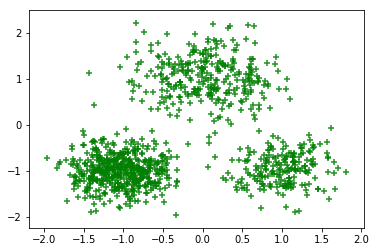

In [3]:
#初期設定
N = 1000 #データ数
#mu = [[-3,-3],[2,2]]
mu = [[0,1],[-1,-1],[1,-1],[3,1]]
sigma = [[[0.2,0.],[0.,0.2]],[[0.1,0.],[0.,0.1]],[[0.1,0.],[0.,0.1]],[[0.2,0.],[0.,0.2]]]
pi=[0.3,0.5,0.2,]
k=3 #データ群の個数
K=6 #分布の個数
D=2 #次元
samples = dataset(mu,sigma,pi)
plt.scatter(samples[:,0],samples[:,1],color='g',marker='+',alpha=0.2)

In [4]:
def make_gauss_model(mu,sigma):
    gauss = []
    for i in range(K):
        gauss.append(multivariate_normal(mean=mu[i],cov=sigma[i]))
        
    return gauss

In [5]:
def draw(gauss):
    plt.figure(figsize=(5, 5))
    # ガウス分布を等高線で描画
    x,y = np.meshgrid(np.linspace(min(samples[:,0]),max(samples[:,0]),1000),np.linspace(min(samples[:,1]),max(samples[:,1]),1000))
    pos = np.dstack((x,y))
    for i in range(K):
        z = gauss[i].pdf(pos)
        plt.contour(x, y, z,colors=clus[i],alpha=0.8)
    #plt.xlim(-5.1, 5.1)
    #plt.ylim(-5.1, 5.1)
    plt.scatter(samples[:,0],samples[:,1],color="g",marker='+',alpha=0.3)

In [6]:
def draw2(gauss,ganma):
    plt.figure(figsize=(5, 5))
    # ガウス分布を等高線で描画
    x,y = np.meshgrid(np.linspace(min(samples[:,0]),max(samples[:,0]),1000),np.linspace(min(samples[:,1]),max(samples[:,1]),1000))
    pos = np.dstack((x,y))
    for i in range(K):
        z = gauss[i].pdf(pos)
        if pi[i] > 0.01: 
            plt.contour(x, y, z,colors=clus[i],alpha=0.8)
    for i in range(N):
        #plt.xlim(min(samples[:,0])+0.1,max(samples[:,0])+0.1)
        #plt.ylim(min(samples[:,1])+0.1,max(samples[:,1])+0.1)
        plt.scatter(samples[i][0],samples[i][1],color="g",marker='+',alpha=0.3)

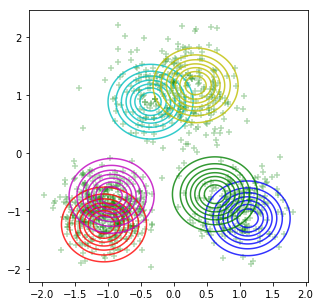

In [7]:
g_mean = [[-1.0574489772985471, -1.2323082405966455], [1.1194494086949569, -1.125715987311797], [-0.35151806160409088, 0.88568695657557817], [-0.94164308644380812, -0.73865348733702973], [0.33074448223827357, 1.1670779444293959], [0.62433751811043658, -0.71019232198881976]]
g_sigma = [[[0.1,0],[0,0.1]],
        [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]]]
pi = [1.0/K for i in range(K)]
clus = ["r","b","c","m","y","g","k", '#f781bf']
gauss = make_gauss_model(g_mean,g_sigma)
draw(gauss)

In [8]:
def ganma_cal():
    ganma = []
    for i in range(N):
        sum_p = 0.0
        p=[]
        for j in range(K):
            sum_p += pi[j]*gauss[j].pdf([samples[i][0],samples[i][1]])
        for j in range(K):
            p.append(pi[j]*gauss[j].pdf([samples[i][0],samples[i][1]])/sum_p)
        ganma.append(p)
    return ganma

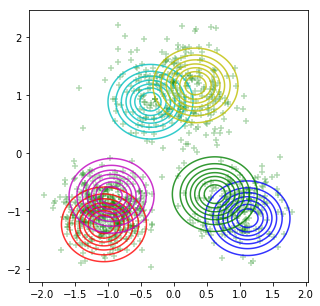

In [9]:
ganma = ganma_cal()
draw2(gauss,ganma)

In [10]:
def cal(ganma):
    N_k = []
    for k in range(K):
        sum_r = 0.0
        for n in range(N):
             sum_r += ganma[n][k]
        N_k.append(sum_r)
    return N_k

In [11]:
N_k = []
N_k = cal(ganma)
print(N_k)

[260.75518341891177, 123.4174148612349, 132.24862580429499, 237.84567525808492, 159.27269111581305, 86.460409541659843]


In [12]:
mu = np.zeros((K,D))
S = np.zeros((K,D,D))

In [13]:
def cal_3(N_k,ganma):
    #行列の初期化
    #mu = np.zeros((K,D))
    #S = np.zeros((K,D,D))
    for k in range(K):
        sum_r = 0.0
        sum_x = 0.0
        sum_y = 0.0
        for n in range(N):
            sum_r += ganma[n][k]*samples[n]
        mu[k] = sum_r/N_k[k]
        sigma = []
        sigma = [samples[j]-mu[k] for j in range(N)]
        tmp = np.zeros((1,D,D))
        for n in range(N):
            tmp += (ganma[n][k]*sigma[n])*sigma[n][:, np.newaxis]
        tmp2 = tmp/N_k[k]
        S[k] = tmp2
    return mu,S

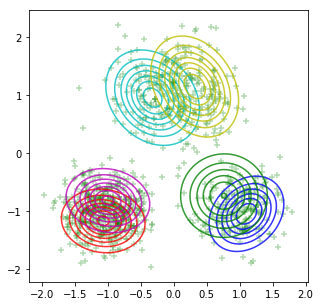

In [14]:
mu,S = cal_3(N_k,ganma)
gauss = make_gauss_model(mu,S)
draw2(gauss,ganma)

In [15]:
def M_step(N_k,mu,S):
    alpha_0 = 0.001
    beta_0 = 0.001
    nu_0 = 1.0
    m_0 = np.zeros((K,D))
    m = np.zeros((K,D))
    W_0 = np.identity(2)
    alpha=[]
    beta=[]
    nu=[]
    W = np.zeros((K,D,D))
    for k in range(K):
        alpha.append(alpha_0 + N_k[k])
        beta.append(beta_0 + N_k[k])
        nu.append(nu_0 + N_k[k])
        m[k] = (beta_0*m_0[k] + N_k[k]*mu[k])/beta[k]
    sigma = []
    sigma = [mu[j]-m_0[j] for j in range(K)]
    for k in range(K):
        tmp = beta_0*N_k[k]*sigma[k]*sigma[k][:, np.newaxis]/(beta_0 + N_k[k])
        tmp2 = la.inv(W_0)+N_k[k]*S[k]+tmp
        W[k] = la.inv(tmp2)
    return alpha,beta,nu,m,W

In [16]:
def E_step(alpha,beta,nu,m,W):
    E_ln_A = []
    E_ln_pi = []
    E_mu_A = []
    r = []
    for k in range(K):
        tmp = sum([digamma((nu[k]+1-i)/2)for i in range(1,D+1)])
        E = tmp +D*math.log(2)+math.log(la.norm(W[k]))
        E_ln_A.append(E)
        
        E = digamma(alpha[k])-digamma(sum(alpha))
        E_ln_pi.append(E)
    for n in range(N):
        tmp = [(D/beta[k])+nu[k]*np.dot((samples[n] - m[k]),np.dot(W[k],(samples[n] - m[k]).T)) for k in range(K)]
        E_mu_A.append(tmp)
    for n in range(N):
        tmp = [np.exp(np.array(E_ln_pi[k]) + np.array(E_ln_A[k])/2 - D*math.log(2*math.pi)/2-np.array(E_mu_A[n][k])/2) for k in range(K)]
        for k in range(K):
            if tmp[k] < 1e-10:
                tmp[k] = 1e-10
        tmp2 = np.array(tmp)/sum(tmp)
        
        r.append(tmp2)
    return E_ln_A,E_ln_pi,E_mu_A,r

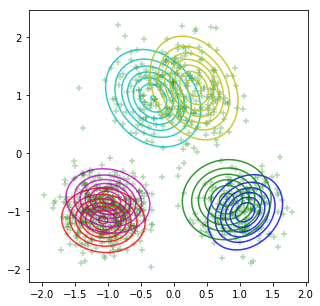

red,green,blue,yellow,cyan,magenta
[ 0.26038496  0.1229795   0.13181505  0.23746415  0.15885242  0.08600438]


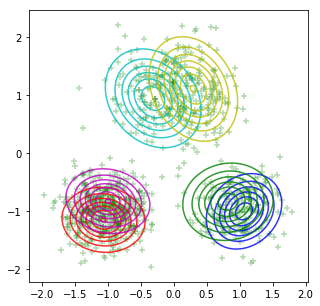

red,green,blue,yellow,cyan,magenta
[ 0.26427753  0.1280072   0.13093809  0.23375014  0.16466848  0.07585907]


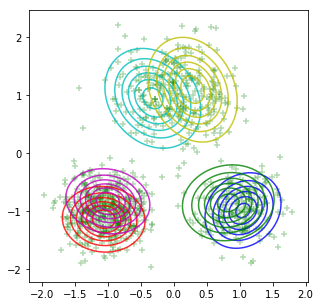

red,green,blue,yellow,cyan,magenta
[ 0.26935792  0.13537804  0.12795847  0.22874795  0.16988388  0.06617431]


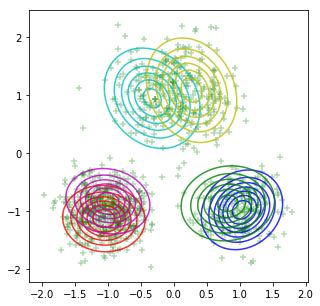

red,green,blue,yellow,cyan,magenta
[ 0.27629519  0.14613033  0.12344727  0.22186474  0.17549106  0.0542721 ]


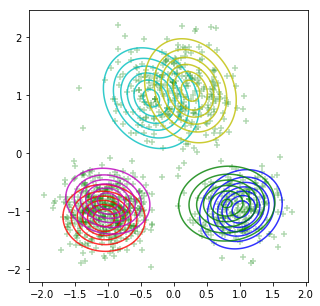

red,green,blue,yellow,cyan,magenta
[ 0.28584621  0.16013835  0.11732063  0.21235379  0.18215903  0.03968295]


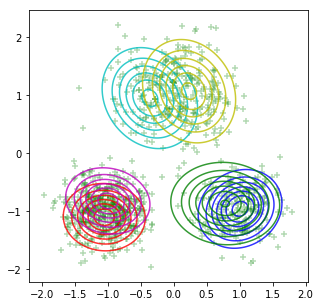

red,green,blue,yellow,cyan,magenta
[ 0.29904849  0.17559551  0.10926802  0.19918943  0.19045521  0.02394499]


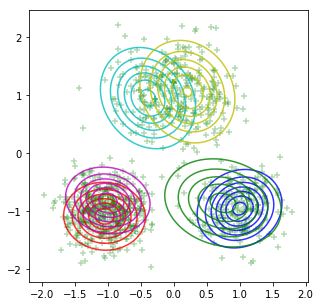

red,green,blue,yellow,cyan,magenta
[ 0.31722062  0.18882519  0.0988517   0.18105571  0.20096061  0.01059004]


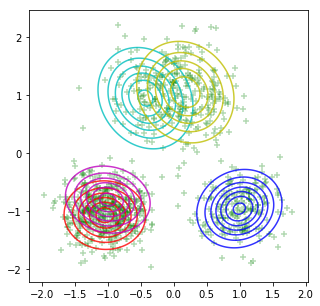

red,green,blue,yellow,cyan,magenta
[ 0.34180303  0.19664211  0.08558962  0.1565069   0.21428185  0.00269176]


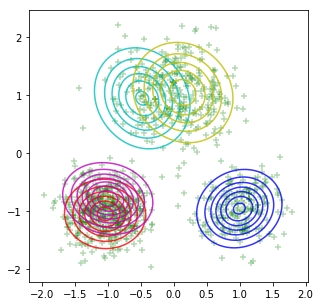

red,green,blue,yellow,cyan,magenta
[  3.73748345e-01   1.99384576e-01   6.90883571e-02   1.24588559e-01
   2.30864182e-01   4.05717717e-05]


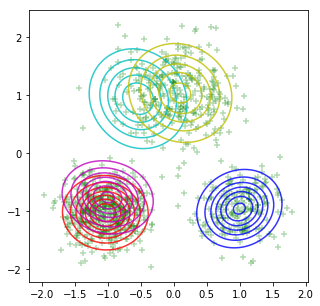

red,green,blue,yellow,cyan,magenta
[ 0.41192632  0.1997003   0.04951491  0.08641159  0.25044665  0.        ]


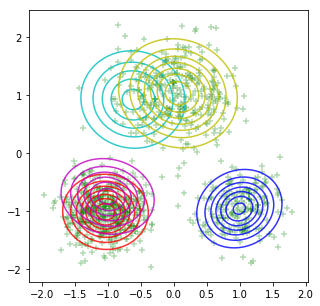

red,green,blue,yellow,cyan,magenta
[ 0.45073542  0.19964838  0.0287499   0.04762386  0.2712432   0.        ]


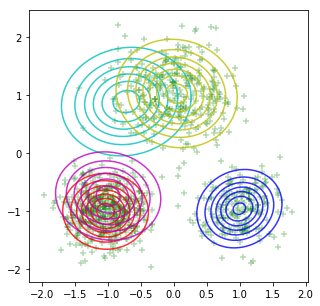

red,green,blue,yellow,cyan,magenta
[ 0.48030344  0.19954216  0.01145418  0.0180949   0.28860967  0.        ]


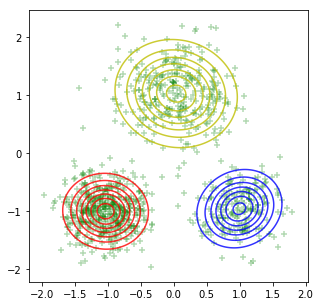

red,green,blue,yellow,cyan,magenta
[ 0.49470824  0.19943479  0.0022851   0.00372499  0.29787429  0.        ]


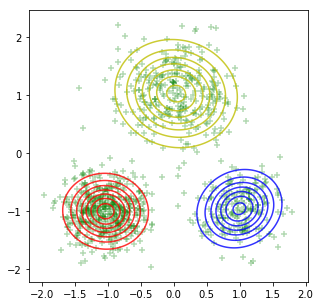

red,green,blue,yellow,cyan,magenta
[  4.98513776e-01   1.99372800e-01   2.94786107e-06   6.03648703e-05
   3.00562193e-01   0.00000000e+00]


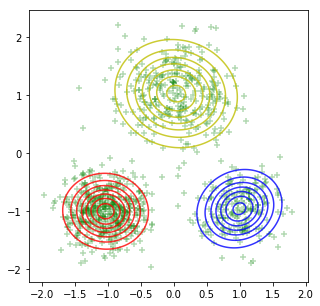

red,green,blue,yellow,cyan,magenta
[ 0.498818    0.1993448   0.          0.          0.30083407  0.        ]


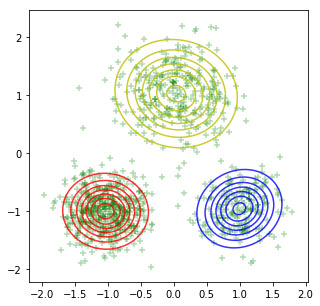

red,green,blue,yellow,cyan,magenta
[ 0.49881191  0.19932908  0.          0.          0.3008559   0.        ]


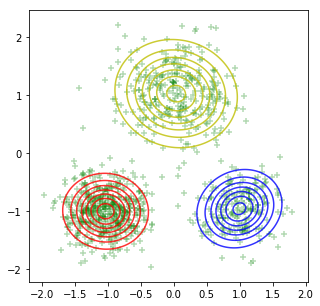

red,green,blue,yellow,cyan,magenta
[ 0.49881036  0.1993243   0.          0.          0.30086223  0.        ]


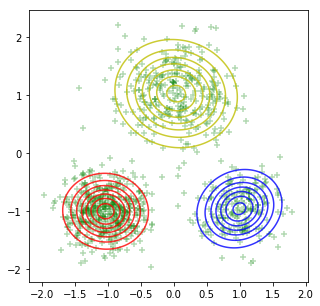

red,green,blue,yellow,cyan,magenta
[ 0.4988099   0.19932285  0.          0.          0.30086415  0.        ]


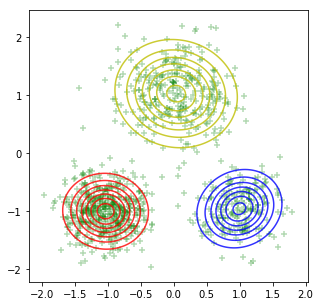

red,green,blue,yellow,cyan,magenta
[ 0.49880975  0.19932241  0.          0.          0.30086474  0.        ]


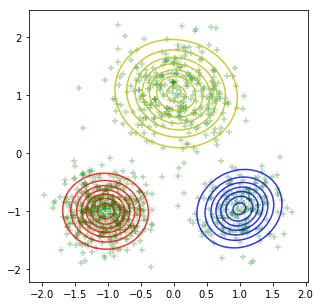

red,green,blue,yellow,cyan,magenta
[ 0.49880971  0.19932227  0.          0.          0.30086492  0.        ]


In [17]:
for i in range(20):
    alpha,beta,nu,m,W = M_step(N_k,mu,S)
    E_ln_A,E_ln_pi,E_mu_A,ganma = E_step(alpha,beta,nu,m,W)
    pi = np.exp(E_ln_pi)
    N_k = cal(ganma)
    mu,S = cal_3(N_k,ganma)
    gauss = make_gauss_model(mu,S)
    draw2(gauss,ganma)
    #['r','g','b','y',"c", "m"]
    plt.show()
    print('red,green,blue,yellow,cyan,magenta')
    print(pi)